<!-- START doctoc generated TOC please keep comment here to allow auto update -->
<!-- DON'T EDIT THIS SECTION, INSTEAD RE-RUN doctoc TO UPDATE -->
**Table of Contents**

- [Monasca Transform](#monasca-transform)
  - [Interactive Notebook](#interactive-notebook)
  - [A.) Import required modules](#a-import-required-modules)
  - [B.) Initialize SparkContext and SQLContext](#b-initialize-sparkcontext-and-sqlcontext)
  - [C.) Read monasca metrics from a file](#c-read-monasca-metrics-from-a-file)
  - [D.) Extract second column containing raw metric json data](#d-extract-second-column-containing-raw-metric-json-data)
  - [E.) Create a raw monasca metrics data frame](#e-create-a-raw-monasca-metrics-data-frame)
  - [F.) Find and plot number of distinct metrics in the raw data](#f-find-and-plot-number-of-distinct-metrics-in-the-raw-data)
  - [G.) Create `pre_transform` specs data frame](#g-create-pre_transform-specs-data-frame)
  - [H.) Filter out unwanted metrics](#h-filter-out-unwanted-metrics)
  - [I.) Validate metrics](#i-validate-metrics)
  - [J.) Generate `record_store` data](#j-generate-record_store-data)
  - [K.)  Create a `transform_context`](#k--create-a-transform_context)
  - [L.) Get a list of `transformation_spec_id` (or `metric_id`'s) to be processed](#l-get-a-list-of-transformation_spec_id-or-metric_ids-to-be-processed)
  - [M.) Create `transform` specs data frame](#m-create-transform-specs-data-frame)
  - [N.) Aggregate metric using `transform_spec`](#n-aggregate-metric-using-transform_spec)
  - [O.)  Display aggregated  `instance_usage` data](#o--display-aggregated--instance_usage-data)
  - [P.) Run hourly processor](#p-run-hourly-processor)
  - [Q.)  Display hourly aggregated  `metric`'s](#q--display-hourly-aggregated--metrics)
  - [R.) Display table of the aggregated `metric`'s](#r-display-table-of-the-aggregated-metrics)

<!-- END doctoc generated TOC please keep comment here to allow auto update -->

# Monasca Transform


## Interactive Notebook

* The notebook exposes a few internal functions/steps in monasca-transform driver [https://github.com/openstack/monasca-transform/blob/master/monasca_transform/driver/mon_metrics_kafka.py](mon_metrics_kafka.py), to make the transformation steps more interactive for the users.


* The caveat is that  that any changes done to the mon_metrics_kafka.py will have to be made to this notebook too.


* This notebook initializes `SparkContext`, `SQLContext` and takes the user through various steps in the transformation processs, which extracts, filters out unwanted data, reads `pre_transform` spec, validates incoming data based on `pre_transform` spec and eventually aggregates the data based on `transform` spec.


* This notebook should be read with along with  [https://github.com/openstack/monasca-transform/blob/master/docs/create-new-aggregation-pipeline.md] "Monasca Transform - Create a new aggregation pipeline" document to create a `pre_transform_spec` and `transform_spec` since it also allows the user to interactively create and test new `pre_transform` and `transform` specifications. 

  See sections "G.) Create `pre_transform` data frame" and "M.) Create `transform_spec` data frame" below
  

* All such internal functions/steps are tagged using tag `INTERNAL` with link back to original  monasca_transform driver code.


* The idea is that users will find it easier to step through this notebook and gain more understanding of how monasca-transform aggregates monasca metrics using Apache Spark.


<!-- Notes: https://etherpad.suse.de/cloud-jupyternotebook -->


## A.) Import required modules

`INTERNAL` (https://github.com/openstack/monasca-transform/blob/master/monasca_transform/driver/mon_metrics_kafka.py)

* Import pyspark, monasca_transform, json and datetime modules required

In [1]:
import json
import datetime

from pyspark import SparkConf
from pyspark.context import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.functions import explode
from pyspark.sql.functions import from_unixtime
from pyspark.sql.functions import when

from pyspark.streaming.kafka import OffsetRange

from monasca_transform.component.insert import InsertComponent
from monasca_transform.driver.mon_metrics_kafka import MonMetricsKafkaProcessor
from monasca_transform.transform.transform_utils import MonMetricUtils
from monasca_transform.transform.transform_utils import PreTransformSpecsUtils
from monasca_transform.transform.transform_utils import TransformSpecsUtils
from monasca_transform.transform import TransformContextUtils
from monasca_transform.processor.pre_hourly_processor import PreHourlyProcessor

## B.) Initialize SparkContext and SQLContext

`INTERNAL` [https://github.com/openstack/monasca-transform/blob/master/monasca_transform/driver/mon_metrics_kafka.py#L570]

* Create `pyspark.SparkContext` and `pyspark.SQLContext` objects

In [2]:
spark_conf = SparkConf()\
                 .setMaster('local[4]')\
                 .setAppName("Monasca Transform Create Aggregation Pipeline Notebook")\
                 .set("spark.sql.shuffle.partitions", "10")
spark_context = SparkContext.getOrCreate(
                conf=spark_conf)
sql_context = SQLContext.getOrCreate(
                spark_context)

## C.) Read monasca metrics from a file


`INTERNAL` 


* Metrics are read from kafka using Spark Streaming in mon_metrics_kafka.py drive, but foor this notebook purposes, metrics are read from file and converted to a Spark RDD 


* See `parallelize()` (https://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.SparkContext)


In [3]:
with open('/home/vagrant/juptest/all_metrics_10000.txt') as f:
    raw_lines = f.read().splitlines()

raw_tuple_list = [eval(raw_line) for raw_line in raw_lines]
raw_data_rdd = spark_context.parallelize(raw_tuple_list)

## D.) Extract second column containing raw metric json data


`INTERNAL` (https://github.com/openstack/monasca-transform/blob/master/monasca_transform/driver/mon_metrics_kafka.py#L309-L313)


* Raw metrics in kafka in form of a tuple

> ('583d49ab6aca482da653dd838deaf538load.avg_5_minhostnamedevstack','{"metric":{"name":"mem.total_mb","dimensions":{"service":"monitoring","hostname":"mini-mon"},"timestamp":1453308031000,"value":8192.0},"meta":{"tenantId":"583d49ab6aca482da653dd838deaf538","region":"useast"},"creation_time":1453308032}')


* The transformation below extracts the second column in the tuple using map() transformation


* See `map()` function in [https://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD]

In [4]:
#
# extract second column containing raw metric data
#
raw_mon_metrics = raw_data_rdd.map(lambda nt: nt[1])

## E.) Create a raw monasca metrics data frame


`INTERNAL` (https://github.com/openstack/monasca-transform/blob/master/monasca_transform/driver/mon_metrics_kafka.py#L315-L321)


* Uses `monasca_transform.transform.transform_utils.MonMetricUtils` to create a Spark DataFrame from JSON data

In [5]:
#
# convert raw metric data rdd to dataframe rdd
#
raw_mon_metrics_df = \
                MonMetricUtils.create_mon_metrics_df_from_json_rdd(
                    sql_context,
                    raw_mon_metrics)

## F.) Find and plot number of distinct metrics in the raw data


`EXPERIMENTAL` This is experimental only - just to play with jupyter notebook plots and not a part of the actual `mon_metrics_kafka.py` driver code.


Find the number of distinct metrics in the raw metric data and plots a bar graph showing the number of each distinct metric

In [6]:
#
# group by metric name
#
raw_mon_metrics_distinct_df = \
    raw_mon_metrics_df.groupBy(
    raw_mon_metrics_df.metric['name'].alias("metric_name")).count()

# 
# get metric name and count
#
raw_mon_metrics_distinct = raw_mon_metrics_distinct_df.sort(["count","metric_name"], ascending=False)

raw_mon_metrics_distinct.show(100)

+--------------------+-----+
|         metric_name|count|
+--------------------+-----+
|  net.in_packets_sec|  527|
|net.in_packets_dr...|  526|
|   net.in_errors_sec|  524|
|    net.in_bytes_sec|  524|
|net.out_packets_d...|  523|
|   net.out_bytes_sec|  523|
|      net.int_status|  523|
| net.out_packets_sec|  522|
|  net.out_errors_sec|  522|
|disk.space_used_perc|  399|
|disk.inode_used_perc|  266|
|      load.avg_5_min|  134|
|      load.avg_1_min|  134|
|     load.avg_15_min|  134|
|     mem.used_shared|  133|
|    mem.used_real_mb|  133|
|      mem.used_cache|  133|
|    mem.used_buffers|  133|
|     mem.usable_perc|  133|
|       mem.usable_mb|  133|
|        mem.total_mb|  133|
|    mem.swap_used_mb|  133|
|   mem.swap_total_mb|  133|
|  mem.swap_free_perc|  133|
|    mem.swap_free_mb|  133|
|         mem.free_mb|  133|
|   io.write_time_sec|  133|
|    io.write_req_sec|  133|
| io.write_kbytes_sec|  133|
|    io.read_time_sec|  133|
|     io.read_req_sec|  133|
|  io.read_kby

In [7]:
%matplotlib inline

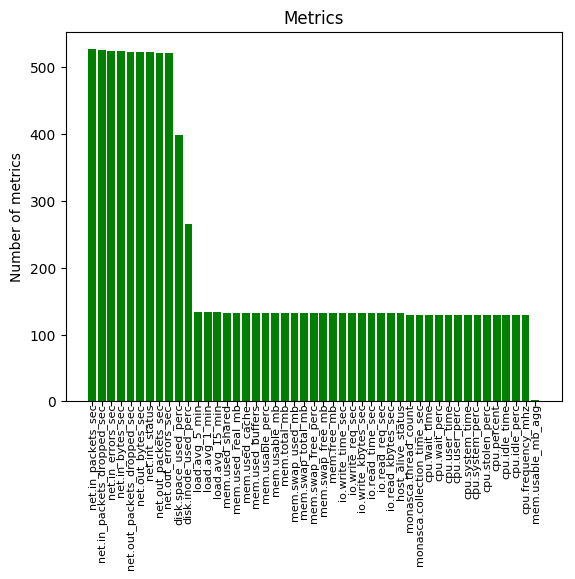

In [8]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcdefaults()
fig, ax = plt.subplots()

# set figure size
plt.rcParams["figure.figsize"] = (20,3)


metric_name_list = []
count_list = []

#
# 
#
for item in raw_mon_metrics_distinct.collect():
    metric_name_list.append(item[0])
    count_list.append(item[1])

#
# set up x axis
#
x_pos = np.arange(len(metric_name_list))
ax.bar(x_pos, count_list, align='center',
        color='green', ecolor='black')
ax.set_xticks(x_pos)
ax.set_xticklabels(metric_name_list, {'va': "baseline",
                                     'rotation': 90,
                                     'size': 8})
ax.set_ylabel('Number of metrics')
ax.set_title('Metrics')
plt.show()

## G.) Create `pre_transform` specs data frame


`INTERNAL` (https://github.com/openstack/monasca-transform/blob/master/monasca_transform/driver/mon_metrics_kafka.py#L303-L307)


* In `mon_metrics_kafka.py` driver, `pre_transform` specs are retrieved from the mysql database, but for this notebook we can add json directly in the next code block.


* Use spec from "Step 2: Create *pre_transform* spec at (https://github.com/openstack/monasca-transform/blob/master/docs/create-new-aggregation-pipeline.md)


In [9]:
#
# get pre transform specs df
#
pre_transform_specs_json='''{"event_processing_params":{
    "set_default_zone_to":"1",
    "set_default_geolocation_to":"1",
    "set_default_region_to":"W"
  },
  "event_type":"monasca.collection_time_sec", 
  "metric_id_list":["monasca_collection_host"], 
  "required_raw_fields_list":["creation_time", "dimensions#hostname"],
  "service_id":"host_metrics"}'''

pre_transform_specs_json_list = [json.loads(pre_transform_specs_json)]
        
pre_transform_specs_json_rdd = spark_context.parallelize(pre_transform_specs_json_list)

pre_transform_specs_df =  PreTransformSpecsUtils.pre_transform_specs_rdd_to_df(pre_transform_specs_json_rdd)

pre_transform_specs_df.show()


+-----------------------+--------------------+--------------------+------------------------+------------+
|event_processing_params|          event_type|      metric_id_list|required_raw_fields_list|  service_id|
+-----------------------+--------------------+--------------------+------------------------+------------+
|                [1,1,W]|monasca.collectio...|[monasca_collecti...|    [creation_time, d...|host_metrics|
+-----------------------+--------------------+--------------------+------------------------+------------+



## H.) Filter out unwanted metrics


`INTERNAL` (https://github.com/openstack/monasca-transform/blob/master/monasca_transform/driver/mon_metrics_kafka.py#L323-L330)


* This transformation uses a `inner` join between the `raw_mon_metrics_df` and `pre_transform_specs` data frames to exclude all the records that arent specified in the `pre_transform` specifications


In [10]:
#
# filter out unwanted metrics and keep metrics we are interested in
#
cond = [raw_mon_metrics_df.metric["name"] == 
            pre_transform_specs_df.event_type]
filtered_metrics_df = raw_mon_metrics_df.join(
    pre_transform_specs_df, cond)
filtered_metrics_df.show()

+-------------+--------------------+--------------------+-----------------------+--------------------+--------------------+------------------------+------------+
|creation_time|                meta|              metric|event_processing_params|          event_type|      metric_id_list|required_raw_fields_list|  service_id|
+-------------+--------------------+--------------------+-----------------------+--------------------+--------------------+------------------------+------------+
|   1526511499|Map(region -> Reg...|[Map(hostname -> ...|                [1,1,W]|monasca.collectio...|[monasca_collecti...|    [creation_time, d...|host_metrics|
|   1526512039|Map(region -> Reg...|[Map(hostname -> ...|                [1,1,W]|monasca.collectio...|[monasca_collecti...|    [creation_time, d...|host_metrics|
|   1526513270|Map(region -> Reg...|[Map(hostname -> ...|                [1,1,W]|monasca.collectio...|[monasca_collecti...|    [creation_time, d...|host_metrics|
|   1526513526|Map(region ->

## I.) Validate metrics  


`INTERNAL` (https://github.com/openstack/monasca-transform/blob/master/monasca_transform/driver/mon_metrics_kafka.py#L332-L343)


* Check if required fields are present and not empty


* Uses `MonMetricsKafkaProcessor._validate_raw_mon_metrics` function for validation


In [11]:
#
# validate filtered metrics to check if required fields
# are present and not empty
# In order to be able to apply filter function had to convert
# data frame rdd to normal rdd. After validation the rdd is
# converted back to dataframe rdd
#
validated_mon_metrics_rdd = filtered_metrics_df.rdd.filter(
    MonMetricsKafkaProcessor._validate_raw_mon_metrics)
            
validated_mon_metrics_df = sql_context.createDataFrame(
                validated_mon_metrics_rdd, filtered_metrics_df.schema)
validated_mon_metrics_df.show()

+-------------+--------------------+--------------------+-----------------------+--------------------+--------------------+------------------------+------------+
|creation_time|                meta|              metric|event_processing_params|          event_type|      metric_id_list|required_raw_fields_list|  service_id|
+-------------+--------------------+--------------------+-----------------------+--------------------+--------------------+------------------------+------------+
|   1526511499|Map(tenantId -> a...|[Map(component ->...|                [1,1,W]|monasca.collectio...|[monasca_collecti...|    [creation_time, d...|host_metrics|
|   1526512039|Map(tenantId -> a...|[Map(component ->...|                [1,1,W]|monasca.collectio...|[monasca_collecti...|    [creation_time, d...|host_metrics|
|   1526513270|Map(tenantId -> a...|[Map(component ->...|                [1,1,W]|monasca.collectio...|[monasca_collecti...|    [creation_time, d...|host_metrics|
|   1526513526|Map(tenantId 

## J.) Generate `record_store` data


`INTERNAL` (https://github.com/openstack/monasca-transform/blob/master/monasca_transform/driver/mon_metrics_kafka.py#L345-481)


* Multiple `record_store` records are generated from a single source metric if the metric is to be aggregated in multiple ways. (that is if there are multiple transformation specs specified in `metric_id_list` of a `pre_transform` spec)


* `record_store` data is normalized and rest of the aggregation components aggregate data in this format.


* Please see Record Store Data Format (https://github.com/openstack/monasca-transform/blob/master/docs/data_formats.md)



In [12]:
#
# record generator
# generate a new intermediate metric record if a given metric
# metric_id_list, in pre_transform_specs table has several
# intermediate metrics defined.
# intermediate metrics are used as a convenient way to
# process (aggregated) metric in mutiple ways by making a copy
# of the source data for each processing
#
gen_mon_metrics_df = validated_mon_metrics_df.select(
    validated_mon_metrics_df.meta,
    validated_mon_metrics_df.metric,
    validated_mon_metrics_df.event_processing_params,
    validated_mon_metrics_df.event_type,
    explode(validated_mon_metrics_df.metric_id_list).alias("this_metric_id"),
    validated_mon_metrics_df.service_id)

#
# transform metrics data to record_store format
# record store format is the common format which will serve as
# source to aggregation processing.
# converting the metric to common standard format helps in writing
# generic aggregation routines driven by configuration parameters
#  and can be reused
#
record_store_df = gen_mon_metrics_df.select(
    (gen_mon_metrics_df.metric.timestamp / 1000).alias(
        "event_timestamp_unix"),
    from_unixtime(
        gen_mon_metrics_df.metric.timestamp / 1000).alias(
        "event_timestamp_string"),
    gen_mon_metrics_df.event_type.alias("event_type"),
    gen_mon_metrics_df.event_type.alias("event_quantity_name"),
    (gen_mon_metrics_df.metric.value / 1.0).alias(
        "event_quantity"),
    # resource_uuid
    when(gen_mon_metrics_df.metric.dimensions.instanceId != '',
         gen_mon_metrics_df.metric.dimensions.instanceId).when(
            gen_mon_metrics_df.metric.dimensions.resource_id != '',
            gen_mon_metrics_df.metric.dimensions.resource_id).otherwise('NA').alias("resource_uuid"),
    # tenant_id
    when(gen_mon_metrics_df.metric.dimensions.tenantId != '',
         gen_mon_metrics_df.metric.dimensions.tenantId).when(
             gen_mon_metrics_df.metric.dimensions.tenant_id != '',
             gen_mon_metrics_df.metric.dimensions.tenant_id).when(
                 gen_mon_metrics_df.metric.dimensions.project_id != '',
                 gen_mon_metrics_df.metric.dimensions.project_id).otherwise(
            'NA').alias("tenant_id"),
    # user_id
    when(gen_mon_metrics_df.meta.userId != '',
         gen_mon_metrics_df.meta.userId).otherwise('NA').alias(
            "user_id"),
        # region
    when(gen_mon_metrics_df.meta.region != '',
         gen_mon_metrics_df.meta.region).when(
            gen_mon_metrics_df.event_processing_params
            .set_default_region_to != '',
         gen_mon_metrics_df.event_processing_params
            .set_default_region_to).otherwise(
           'NA').alias("region"),

    # zone
    when(gen_mon_metrics_df.meta.zone != '',
         gen_mon_metrics_df.meta.zone).when(
            gen_mon_metrics_df.event_processing_params
            .set_default_zone_to != '',
            gen_mon_metrics_df.event_processing_params
                         .set_default_zone_to).otherwise(
                             'NA').alias("zone"),

    # host
    when(gen_mon_metrics_df.metric.dimensions.hostname != '',
         gen_mon_metrics_df.metric.dimensions.hostname).when(
            gen_mon_metrics_df.metric.value_meta.host != '',
            gen_mon_metrics_df.metric.value_meta.host).otherwise(
            'NA').alias("host"),

    # event_date
    from_unixtime(gen_mon_metrics_df.metric.timestamp / 1000,
              'yyyy-MM-dd').alias("event_date"),
    # event_hour
    from_unixtime(gen_mon_metrics_df.metric.timestamp / 1000,
               'HH').alias("event_hour"),
    # event_minute
    from_unixtime(gen_mon_metrics_df.metric.timestamp / 1000,
              'mm').alias("event_minute"),

    # event_second
    from_unixtime(gen_mon_metrics_df.metric.timestamp / 1000,
              'ss').alias("event_second"),

    gen_mon_metrics_df.this_metric_id.alias("metric_group"),

    gen_mon_metrics_df.this_metric_id.alias("metric_id"),

    # metric dimensions
    gen_mon_metrics_df.meta.alias("meta"),
    # metric dimensions
    gen_mon_metrics_df.metric.dimensions.alias("dimensions"),
    # metric value_meta
    gen_mon_metrics_df.metric.value_meta.alias("value_meta"))


record_store_df.show()

            

+--------------------+----------------------+--------------------+--------------------+--------------+-------------+---------+-------+---------+----+--------+----------+----------+------------+------------+--------------------+--------------------+--------------------+--------------------+----------+
|event_timestamp_unix|event_timestamp_string|          event_type| event_quantity_name|event_quantity|resource_uuid|tenant_id|user_id|   region|zone|    host|event_date|event_hour|event_minute|event_second|        metric_group|           metric_id|                meta|          dimensions|value_meta|
+--------------------+----------------------+--------------------+--------------------+--------------+-------------+---------+-------+---------+----+--------+----------+----------+------------+------------+--------------------+--------------------+--------------------+--------------------+----------+
| 1.526511495903597E9|   2018-05-16 22:58:15|monasca.collectio...|monasca.collectio...|  0.037

## K.)  Create a `transform_context`


* `transform_context` is a NamedTuple which contains offset information along with the batch date time information


* For the purpose of this notebook create a `transform_context` with dummy data


In [13]:
#
# create a transform_context
#

# decorate mocked RDD with dummy kafka offsets
myOffsetRanges = [OffsetRange("metrics", 1, 10, 20)]
    
my_batch_time = datetime.datetime.strptime('2016-01-01 00:00:00',
                                            '%Y-%m-%d %H:%M:%S')
transform_context = \
    TransformContextUtils.get_context(offset_info=myOffsetRanges,
                                      batch_time_info=my_batch_time)

## L.) Get a list of `transformation_spec_id` (or `metric_id`'s) to be processed


`INTERNAL` (https://github.com/openstack/monasca-transform/blob/master/monasca_transform/driver/mon_metrics_kafka.py#L236-L241)


* Note: There should be a transformation spec (see next section) for each `transformation_spec_id` (or `metric_id`) 

In [14]:
#
# look in record_store_df for list of metrics to be processed
#
metric_ids_df = record_store_df.select("metric_id").distinct()
metric_ids_to_process = [row.metric_id for row in metric_ids_df.collect()]
print metric_ids_to_process


[u'monasca_collection_host']


## M.) Create `transform` specs data frame


`INTERNAL` (https://github.com/openstack/monasca-transform/blob/master/monasca_transform/driver/mon_metrics_kafka.py#L236-L241)


* In `mon_metrics_kafka.py` driver, `transform` specs are retrieved from the mysql database, but for this notebook we can add json directly in the next code block.


* Use spec from `Step 3: Create a "transform_spec" to find maximum metric value for each host` at (https://github.com/openstack/monasca-transform/blob/master/docs/create-new-aggregation-pipeline.md)


In [15]:
#
# get pre transform specs df
#
transform_specs_json='''{"aggregation_params_map":{

  "aggregation_pipeline":{
    "source":"streaming",
    "usage":"fetch_quantity", 
    "setters":["set_aggregated_metric_name","set_aggregated_period"], 
    "insert":["insert_data_pre_hourly"]
  },

  "aggregated_metric_name":"monasca.collection_time_sec_host_agg",
  "aggregation_period":"hourly", 
  "aggregation_group_by_list": ["host"],
  "usage_fetch_operation": "max",
  "filter_by_list": [],
  "dimension_list":["aggregation_period","host"],

  "pre_hourly_operation":"max",
  "pre_hourly_group_by_list":["default"]},

  "metric_group":"monasca_collection_host",
  "metric_id":"monasca_collection_host"}'''

transform_specs_json_list = [json.loads(transform_specs_json)]
        
transform_specs_json_rdd = spark_context.parallelize(transform_specs_json_list)

transform_specs_df =  TransformSpecsUtils.transform_specs_rdd_to_df(transform_specs_json_rdd)

transform_specs_df.show()


+----------------------+--------------------+
|aggregation_params_map|           metric_id|
+----------------------+--------------------+
|  [hourly,WrappedAr...|monasca_collectio...|
+----------------------+--------------------+



## N.) Aggregate metric using `transform_spec`


`INTERNAL` (https://github.com/openstack/monasca-transform/blob/master/monasca_transform/driver/mon_metrics_kafka.py#L264-L289)


* Each `usage`, `setters` and `insert` generic aggregation component specified in `transform_spec` above is invoked and final end product is a aggregated `instance_usage` data frame 


In [16]:

for metric_id in metric_ids_to_process:
    transform_spec_df = transform_specs_df.select(
        ["aggregation_params_map", "metric_id"]
    ).where(transform_specs_df.metric_id == metric_id)
    
    source_record_store_df = record_store_df.select("*").where(
    record_store_df.metric_id == metric_id)

     # set transform_spec_df in TransformContext
    transform_context = \
        TransformContextUtils.get_context(
            transform_context_info=transform_context,
            transform_spec_df_info=transform_spec_df)
    
    agg_inst_usage_df = (
        MonMetricsKafkaProcessor.process_metric(
            transform_context, source_record_store_df))
    agg_inst_usage_df.show(5)

+---------+-------+-------------+-----------+------+----+--------+----------+----------------------+----------------------------+---------------------------+----------+----------+------------+------------------+--------------------------+-------------------------+------------+------------+--------------------+--------------------+
|tenant_id|user_id|resource_uuid|geolocation|region|zone|    host|project_id|aggregated_metric_name|firstrecord_timestamp_string|lastrecord_timestamp_string|usage_date|usage_hour|usage_minute|aggregation_period|firstrecord_timestamp_unix|lastrecord_timestamp_unix|    quantity|record_count|     processing_meta|      extra_data_map|
+---------+-------+-------------+-----------+------+----+--------+----------+----------------------+----------------------------+---------------------------+----------+----------+------------+------------------+--------------------------+-------------------------+------------+------------+--------------------+--------------------+
|

## O.)  Display aggregated  `instance_usage` data


`INTERNAL` Aggregated `instance_usage` data is written to Kafka's `pre_hourly_metrics` topic directly. 


But for this notebook we will use `InsertComponent._get_instance_usage_pre_hourly` method to get aggregated `instance_usage` data and convert it into JSON using `json.dumps()` method

In [17]:
agg_metrics = []

for row in agg_inst_usage_df.collect():
    metric_dict = \
        InsertComponent._get_instance_usage_pre_hourly(
            row, "monasca_collection_host")
    metric = json.dumps(metric_dict, separators=(',', ':'))
    agg_metrics.append(metric_dict)
    
agg_metrics

[{'aggregated_metric_name': u'monasca.collection_time_sec_host_agg',
  'aggregation_period': u'hourly',
  'extra_data_map': {u'event_date': u'2018-05-17',
   u'event_hour': u'09',
   u'host': u'devstack'},
  'firstrecord_timestamp_string': u'2018-05-17 09:03:48',
  'firstrecord_timestamp_unix': 1526547828.872482,
  'geolocation': u'NA',
  'host': u'devstack',
  'lastrecord_timestamp_string': u'2018-05-17 09:28:50',
  'lastrecord_timestamp_unix': 1526549330.228031,
  'processing_meta': {u'event_type': u'NA',
   'metric_id': 'monasca_collection_host'},
  'project_id': u'NA',
  'quantity': 0.0547680855,
  'record_count': 4.0,
  'region': u'NA',
  'resource_uuid': u'NA',
  'tenant_id': u'NA',
  'usage_date': u'2018-05-17',
  'usage_hour': u'09',
  'usage_minute': u'NA',
  'user_id': u'NA',
  'zone': u'NA'},
 {'aggregated_metric_name': u'monasca.collection_time_sec_host_agg',
  'aggregation_period': u'hourly',
  'extra_data_map': {u'event_date': u'2018-05-16',
   u'event_hour': u'22',
   u'

## P.) Run hourly processor

`INTERNAL` Pre Hourly Processor aggregates all `instance_usage` records by hour. All instance usage data records are written to `metrics_pre_hourly` kafka topic. Every hour all `instance_usage` data records for the previous hour are aggregated by the `PreHourlyProcessor` and written to the `metrics` topic in kafka.

* Call `PreHourlyProcessor.process_instance_usage` to run hourly aggregation


In [18]:
instance_usage_data_hourly_df = PreHourlyProcessor.process_instance_usage(transform_context,
                                                                        agg_inst_usage_df)
instance_usage_data_hourly_df.show(100)

+---------+-------+-------------+-----------+------+----+--------+----------+----------------------+----------------------------+---------------------------+----------+----------+------------+------------------+--------------------------+-------------------------+------------+------------+---------------+--------------------+
|tenant_id|user_id|resource_uuid|geolocation|region|zone|    host|project_id|aggregated_metric_name|firstrecord_timestamp_string|lastrecord_timestamp_string|usage_date|usage_hour|usage_minute|aggregation_period|firstrecord_timestamp_unix|lastrecord_timestamp_unix|    quantity|record_count|processing_meta|      extra_data_map|
+---------+-------+-------------+-----------+------+----+--------+----------+----------------------+----------------------------+---------------------------+----------+----------+------------+------------------+--------------------------+-------------------------+------------+------------+---------------+--------------------+
|       NA|     

## Q.)  Display hourly aggregated  `metric`'s


`INTERNAL` Hourly aggregated `instance_usage` data is written to Kafka's `metrics` topic. 


But for this notebook we will use `InsertComponent._get_instance_usage` method to get aggregated `instance_usage` data and convert it into JSON using `json.dumps()` method

In [19]:
agg_metrics = []

agg_params = transform_spec_df.select(
    "aggregation_params_map.dimension_list").collect()[0].asDict()


for row in instance_usage_data_hourly_df.collect():
    metric_dict = \
        InsertComponent._get_metric(row, agg_params)
    metric = json.dumps(metric_dict, separators=(',', ':'))
    agg_metrics.append(metric_dict)
    

agg_metrics

[{'creation_time': 1527196997,
  'meta': {'region': 'RegionOne',
   'tenantId': 'aaa4995657fc4d38b801b90a280d3303'},
  'metric': {'dimensions': {u'aggregation_period': u'hourly',
    u'host': u'devstack'},
   'name': u'monasca.collection_time_sec_host_agg',
   'timestamp': 1527196997846,
   'value': 0.08740592,
   'value_meta': {'firstrecord_timestamp_string': u'2018-05-17 05:05:35',
    'lastrecord_timestamp_string': u'2018-05-17 05:55:53',
    'record_count': 13.0}}},
 {'creation_time': 1527196997,
  'meta': {'region': 'RegionOne',
   'tenantId': 'aaa4995657fc4d38b801b90a280d3303'},
  'metric': {'dimensions': {u'aggregation_period': u'hourly',
    u'host': u'devstack'},
   'name': u'monasca.collection_time_sec_host_agg',
   'timestamp': 1527196997846,
   'value': 0.0826208591,
   'value_meta': {'firstrecord_timestamp_string': u'2018-05-17 02:01:40',
    'lastrecord_timestamp_string': u'2018-05-17 02:58:13',
    'record_count': 16.0}}},
 {'creation_time': 1527196997,
  'meta': {'regio

## R.) Display table of the aggregated `metric`'s

In [20]:
instance_usage_data_hourly_display_df = instance_usage_data_hourly_df.select(
    instance_usage_data_hourly_df.aggregated_metric_name,
    instance_usage_data_hourly_df.quantity,
    instance_usage_data_hourly_df.firstrecord_timestamp_string,
    instance_usage_data_hourly_df.lastrecord_timestamp_string,
    instance_usage_data_hourly_df.record_count).orderBy(
    instance_usage_data_hourly_df.aggregated_metric_name,
    instance_usage_data_hourly_df.firstrecord_timestamp_string,
    instance_usage_data_hourly_df.lastrecord_timestamp_string)

instance_usage_data_hourly_display_df.show(100)



+----------------------+------------+----------------------------+---------------------------+------------+
|aggregated_metric_name|    quantity|firstrecord_timestamp_string|lastrecord_timestamp_string|record_count|
+----------------------+------------+----------------------------+---------------------------+------------+
|  monasca.collectio...|0.0905280113|         2018-05-16 22:48:00|        2018-05-16 22:59:45|         6.0|
|  monasca.collectio...|0.0464491844|         2018-05-16 23:07:16|        2018-05-16 23:50:03|        11.0|
|  monasca.collectio...|0.0571830273|         2018-05-17 00:02:04|        2018-05-17 00:54:22|        11.0|
|  monasca.collectio...|0.0824072361|         2018-05-17 01:02:52|        2018-05-17 01:51:55|        13.0|
|  monasca.collectio...|0.0826208591|         2018-05-17 02:01:40|        2018-05-17 02:58:13|        16.0|
|  monasca.collectio...|0.0808901787|         2018-05-17 03:01:29|        2018-05-17 03:59:32|        14.0|
|  monasca.collectio...|0.06

**END**